In [14]:
from explainers.GNNBoundary.gnn_boundary.models.gcn_classifier import GCNClassifier as GCNClassifier
import torch as torch

In [15]:
import numpy as np

In [16]:

model = GCNClassifier(num_layers=3, num_classes=4, node_features=3, hidden_channels=32)
model.load_state_dict(torch.load('model/report_models/multi_grids.pt'))

<All keys matched successfully>

In [17]:
from graph_generation.MultiGraphs import MultiGraphs
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(MultiGraphs(10000, negative_class=True).getDataset())
mean_embeds = dataset.mean_embeddings(model)


In [18]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   0,    4,    8, ..., 9988, 9992, 9996]),
 array([   1,    5,    9, ..., 9989, 9993, 9997]),
 array([   2,    6,   10, ..., 9990, 9994, 9998]),
 array([   3,    7,   11, ..., 9991, 9995, 9999])]

In [19]:

trainers = {}

In [24]:
from explainers.gnninterpreter import *
c = 0

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=25,
                num_node_cls=3,
                temperature=0.15,
                learn_node_feat=True
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=5),
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=3, mode='minimize'), weight=5),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=5),
                dict(key="logits", criterion=MeanPenalty(), weight=0),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )
trainers[c].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=4 m=2
logits=[-43.22081756591797, -60.8301887512207, -2.0228562355041504, -39.410850524902344]
probs=[1.282192815183747e-18, 2.8860285165260234e-26, 1.0, 5.78896594518173e-17]


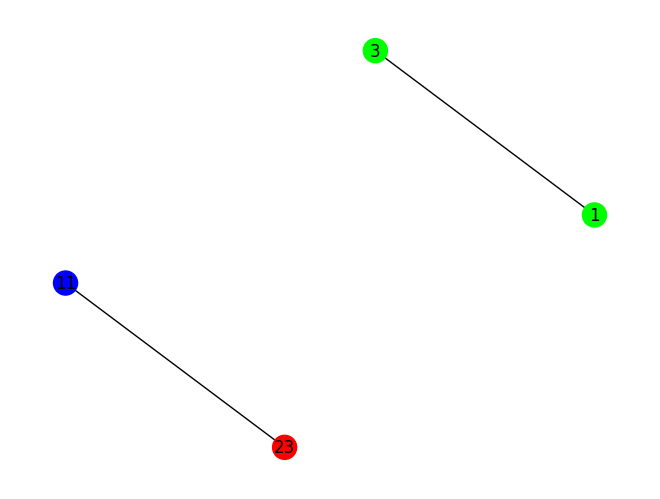

(<networkx.classes.graph.Graph at 0x7fe60d2194e0>,
 {'n': 4,
  'm': 2,
  'logits': [-43.22081756591797,
   -60.8301887512207,
   -2.0228562355041504,
   -39.410850524902344],
  'probs': [1.282192815183747e-18,
   2.8860285165260234e-26,
   1.0,
   5.78896594518173e-17]})

In [21]:
trainers[2].evaluate(threshold=0.5, show=True)

n=4 m=2
logits=[-39.32041931152344, 5.593085765838623, -38.78059005737305, -18.450393676757812]
probs=[3.121133720038996e-20, 1.0, 5.354972445859954e-20, 3.6145093862405275e-11]


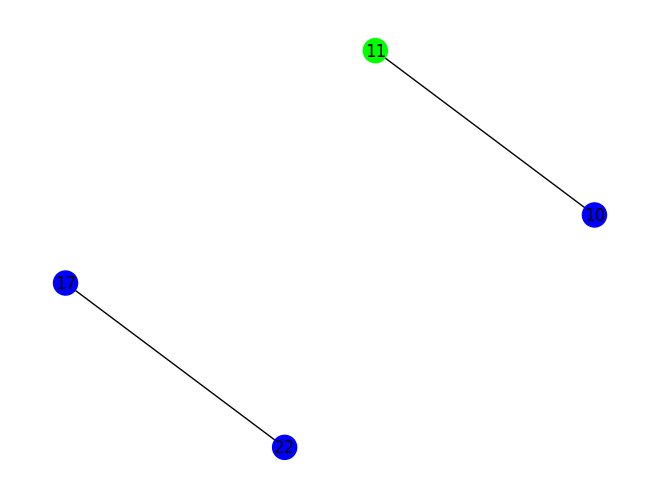

(<networkx.classes.graph.Graph at 0x7fe60d21aa10>,
 {'n': 4,
  'm': 2,
  'logits': [-39.32041931152344,
   5.593085765838623,
   -38.78059005737305,
   -18.450393676757812],
  'probs': [3.121133720038996e-20,
   1.0,
   5.354972445859954e-20,
   3.6145093862405275e-11]})

In [25]:
trainers[1].evaluate(threshold=0.5, show=True)

n=2 m=1
logits=[-0.783762514591217, -21.63024139404297, -11.302743911743164, -15.598034858703613]
probs=[0.9999725818634033, 8.840505549834177e-10, 2.701796984183602e-05, 3.683253169128875e-07]


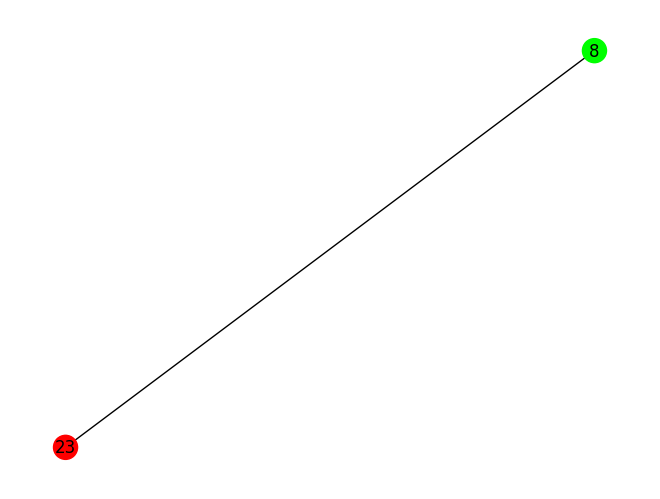

(<networkx.classes.graph.Graph at 0x7fe63d636680>,
 {'n': 2,
  'm': 1,
  'logits': [-0.783762514591217,
   -21.63024139404297,
   -11.302743911743164,
   -15.598034858703613],
  'probs': [0.9999725818634033,
   8.840505549834177e-10,
   2.701796984183602e-05,
   3.683253169128875e-07]})

In [26]:
trainers[0].evaluate(threshold=0.5, show=True)